In [1]:
import pandas as pd
import numpy as np

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize  

# Scrape the web to get the data
from bs4 import BeautifulSoup
import requests

import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# find the distances
from scipy.spatial.distance import cdist

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# translate Vietnamese character (with accents) 
#     to the closest possible representation in ascii text
from unidecode import unidecode

In [2]:
source_wiki_hcm = requests.get("https://en.wikipedia.org/wiki/Ho_Chi_Minh_City").text
soup = BeautifulSoup(source_wiki_hcm, 'lxml')
table_wiki_hcm = ( soup.find("span", {"id": "Demographics"})
                    .parent.previous_sibling.previous_sibling )

table_rows = table_wiki_hcm.tbody.find_all("tr")
res_hcm = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    res_hcm.append(row)

In [3]:
df_hcm = pd.DataFrame(res_hcm, columns=["District", "Subdistrict", 
                        "Area (km2)", "", "", "", "", "Population 2015", ""])
df_hcm.drop("", axis=1, inplace=True)
df_hcm = df_hcm.iloc[3:22].reset_index().drop("index", axis=1)
df_hcm["Population 2015"] = (
                            df_hcm["Population 2015"].str.replace("\n", "")
                                .str.replace(",", "")
                                .str.replace(".", "")
                                .str.strip()
                            )
# Add the "Density" column = Population / Area
df_hcm["Density (pop/m2)"] = round(df_hcm["Population 2015"].astype(float) 
                                       / df_hcm["Area (km2)"].astype(float)
                                   , 3)
# remove the word "District"
df_hcm["District"] = ( df_hcm["District"]
                              .str.replace("District", "")
                              .str.strip()
                         )
# remove Vietnamese accents
df_hcm["District"] = df_hcm["District"].apply(unidecode)
df_hcm

,District,Subdistrict,Area (km2),Population 2015,Density (pop/m2)
0,1,10 wards,7.73,193632,25049.418
1,2,11 wards,49.74,147168,2958.745
2,3,14 wards,4.92,196333,39905.081
3,4,15 wards,4.18,186727,44671.531
4,5,15 wards,4.27,178615,41830.211
5,6,14 wards,7.19,258945,36014.604
6,7,10 wards,35.69,310178,8690.894
7,8,16 wards,19.18,431969,22521.846
8,9,13 wards,114,290620,2549.298
9,10,15 wards,5.72,238558,41705.944


# Housing price
Next, we collect the housing price at different districts of HCMC.

In [4]:
source_housing_price = requests.get("https://mogi.vn/gia-nha-dat").text
soup = BeautifulSoup(source_housing_price, 'lxml')
table_housing_price = soup.find("div", class_="mt-table")

In [5]:
table_rows = table_housing_price.find_all("div", class_="mt-row")
res_housing_price = []
for tr in table_rows:
    district = tr.find("div", class_="mt-street").a.text
    medium_price = tr.find("div", class_="mt-vol").span.text
    row = [district, medium_price]
    res_housing_price.append(row)

In [6]:
df_housing_price = pd.DataFrame(res_housing_price, 
                                columns=["District", "Average Housing Price (1M VND)"])
df_housing_price = df_housing_price.iloc[:19].reset_index().drop("index", axis=1)

# Remove the word "Quận"
df_housing_price["District"] = ( df_housing_price["District"]
                                        .str.replace("\n", "").str.replace("Quận", "")
                                        .str.strip() 
                                   )

# Remove Vietnamese accents
df_housing_price["District"] = df_housing_price["District"].apply(unidecode)

# Remove the word "triệu" (It's 10^6 in Vietnamese)
df_housing_price["Average Housing Price (1M VND)"] = ( df_housing_price["Average Housing Price (1M VND)"]
                                                .str.replace("triệu", "")
                                                 .str.replace(",", ".")
                                                 .str.strip()
                                            )
df_housing_price

,District,Average Housing Price (1M VND)
0,1,430 /m2
1,2,81.3 /m2
2,3,272 /m2
3,4,85.7 /m2
4,5,256 /m2
5,6,115 /m2
6,7,86.7 /m2
7,8,67.1 /m2
8,9,48.2 /m2
9,10,213 /m2


In [7]:
df = pd.merge(df_hcm, df_housing_price, how='left', left_on = 'District', right_on = 'District')
df

,District,Subdistrict,Area (km2),Population 2015,Density (pop/m2),Average Housing Price (1M VND)
0,1,10 wards,7.73,193632,25049.418,430 /m2
1,2,11 wards,49.74,147168,2958.745,81.3 /m2
2,3,14 wards,4.92,196333,39905.081,272 /m2
3,4,15 wards,4.18,186727,44671.531,85.7 /m2
4,5,15 wards,4.27,178615,41830.211,256 /m2
5,6,14 wards,7.19,258945,36014.604,115 /m2
6,7,10 wards,35.69,310178,8690.894,86.7 /m2
7,8,16 wards,19.18,431969,22521.846,67.1 /m2
8,9,13 wards,114,290620,2549.298,48.2 /m2
9,10,15 wards,5.72,238558,41705.944,213 /m2


In [8]:
latlong = pd.read_csv('HCMC lat long.csv')
latlong.drop(columns = ['Unnamed: 0'], axis = 1, inplace = True)

In [9]:
latlong

,District,Subdistrict,Latitude,Longitude
0,1,10 wards,10.774540,106.699184
1,2,11 wards,10.791116,106.736729
2,3,14 wards,10.783529,106.687098
3,4,15 wards,10.759243,106.704890
4,5,15 wards,10.756129,106.670375
5,6,14 wards,10.746928,106.634495
6,7,10 wards,10.736573,106.722432
7,8,16 wards,10.740400,106.665843
8,9,13 wards,10.830278,106.817500
9,10,15 wards,10.773198,106.667833


In [10]:
hochiminh_data = df.merge(latlong,how='left', on= df.columns[0])

In [11]:
hochiminh_data

,District,Subdistrict_x,Area (km2),Population 2015,Density (pop/m2),Average Housing Price (1M VND),Subdistrict_y,Latitude,Longitude
0,1,10 wards,7.73,193632,25049.418,430 /m2,10 wards,10.774540,106.699184
1,2,11 wards,49.74,147168,2958.745,81.3 /m2,11 wards,10.791116,106.736729
2,3,14 wards,4.92,196333,39905.081,272 /m2,14 wards,10.783529,106.687098
3,4,15 wards,4.18,186727,44671.531,85.7 /m2,15 wards,10.759243,106.704890
4,5,15 wards,4.27,178615,41830.211,256 /m2,15 wards,10.756129,106.670375
5,6,14 wards,7.19,258945,36014.604,115 /m2,14 wards,10.746928,106.634495
6,7,10 wards,35.69,310178,8690.894,86.7 /m2,10 wards,10.736573,106.722432
7,8,16 wards,19.18,431969,22521.846,67.1 /m2,16 wards,10.740400,106.665843
8,9,13 wards,114,290620,2549.298,48.2 /m2,13 wards,10.830278,106.817500
9,10,15 wards,5.72,238558,41705.944,213 /m2,15 wards,10.773198,106.667833


In [12]:
hochiminh_data = hochiminh_data.drop(columns = ['Subdistrict_y'])
hochiminh_data = hochiminh_data.rename(columns = {'Subdistrict_x' : 'Subdistrict'})

In [13]:
for index in hochiminh_data.index:
    hochiminh_data['Average Housing Price (1M VND)'][index] = hochiminh_data['Average Housing Price (1M VND)'][index].replace(" /m2","")

C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
hochiminh_data['Average Housing Price (1M VND)'] = hochiminh_data['Average Housing Price (1M VND)'].astype('float')

In [16]:
hochiminh_data

,District,Subdistrict,Area (km2),Population 2015,Density (pop/m2),Average Housing Price (1M VND),Latitude,Longitude
0,1,10 wards,7.73,193632,25049.418,430.0,10.774540,106.699184
1,2,11 wards,49.74,147168,2958.745,81.3,10.791116,106.736729
2,3,14 wards,4.92,196333,39905.081,272.0,10.783529,106.687098
3,4,15 wards,4.18,186727,44671.531,85.7,10.759243,106.704890
4,5,15 wards,4.27,178615,41830.211,256.0,10.756129,106.670375
5,6,14 wards,7.19,258945,36014.604,115.0,10.746928,106.634495
6,7,10 wards,35.69,310178,8690.894,86.7,10.736573,106.722432
7,8,16 wards,19.18,431969,22521.846,67.1,10.740400,106.665843
8,9,13 wards,114,290620,2549.298,48.2,10.830278,106.817500
9,10,15 wards,5.72,238558,41705.944,213.0,10.773198,106.667833


In [17]:
address = 'Ho Chi Minh City Vietnam'

geolocator = Nominatim(user_agent="hcmc_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 10.7758439, 106.7017555.


In [18]:
# create map of Ho Chi Minh City using latitude and longitude values
map_hochiminh = folium.Map(location=[latitude,longitude], zoom_start=12)

# add markers to map
for lat, lng, district in zip(hochiminh_data['Latitude'], hochiminh_data['Longitude'], hochiminh_data['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hochiminh)  

map_hochiminh

In [19]:
CLIENT_ID = 'IBURL40ZNL0PDKER1SRGMWSNUN3ORKW5W5DAR1NQB3G00HJZ' # your Foursquare ID
CLIENT_SECRET = 'EGGZGDECWC3NU2HKVZA300CINXA5LS5LUVOKAC5UUEFKLXH4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IBURL40ZNL0PDKER1SRGMWSNUN3ORKW5W5DAR1NQB3G00HJZ
CLIENT_SECRET:EGGZGDECWC3NU2HKVZA300CINXA5LS5LUVOKAC5UUEFKLXH4


# Explore Venues in Ho Chi Minh City
Let's create a function to get nearby venues to all district in Ho Chi Minh City

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

##### Now write the code to run the above function on each district and create a new dataframe called hochiminh_venues.

In [21]:
radius = 500
LIMIT = 100
hochiminh_venues = getNearbyVenues(names=hochiminh_data['District'],
                                   latitudes=hochiminh_data['Latitude'],
                                   longitudes=hochiminh_data['Longitude']
                                  )

1
2
3
4
5
6
7
8
9
10
11
12
Go Vap
Tan Binh
Tan Phu
Binh Thanh
Phu Nhuan
Thu Duc
Binh Tan


In [22]:
print(hochiminh_venues.shape)
hochiminh_venues.head()

(302, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,10.77454,106.699184,Pizza 4P's,10.773301,106.697599,Pizza Place
1,1,10.77454,106.699184,Pasteur Street Brewing Company,10.775220,106.700894,Brewery
2,1,10.77454,106.699184,O Lé,10.774772,106.699524,Spanish Restaurant
3,1,10.77454,106.699184,Annam Gourmet Saigon Centre,10.773204,106.700435,Supermarket
4,1,10.77454,106.699184,Liberty Central Saigon Citypoint Hotel,10.774758,106.700795,Hotel


In [23]:
hochiminh_restaurant = hochiminh_venues[hochiminh_venues['Venue Category'].str.contains('Restaurant')].reset_index()
hochiminh_restaurant.drop(columns=['index'],inplace = True, axis = 1)

Let's check how many venues were returned for each district

In [24]:
hochiminh_restaurant

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,10.774540,106.699184,O Lé,10.774772,106.699524,Spanish Restaurant
1,1,10.774540,106.699184,Bep Me In,10.773810,106.698152,Vietnamese Restaurant
2,1,10.774540,106.699184,Quán Lộc Thành,10.772472,106.698441,Vietnamese Restaurant
3,1,10.774540,106.699184,Got Bun?,10.773799,106.697347,Asian Restaurant
4,1,10.774540,106.699184,Yen Sushi and Sake Pub,10.772086,106.700674,Restaurant
...,...,...,...,...,...,...,...
98,Phu Nhuan,10.800118,106.677042,Cơm Gà Hồng Phát,10.799338,106.677665,Asian Restaurant
99,Phu Nhuan,10.800118,106.677042,Bún Đậu Mắm Tôm Lâm Bô,10.796053,106.676188,Asian Restaurant
100,Thu Duc,10.853246,106.765655,KFC Thủ Đức,10.850711,106.764716,Fast Food Restaurant
101,Binh Tan,10.749809,106.605664,Trung Nguyen,10.753139,106.604008,Brazilian Restaurant


##### Let's find out how many unique categories can be curated from all the returned venues

In [25]:
print('There are {} uniques categories.'.format(len(hochiminh_restaurant['Venue Category'].unique())))

There are 21 uniques categories.


### Analyze Each District

In [26]:
# one hot encoding
hochiminh_restaurant_onehot = pd.get_dummies(hochiminh_restaurant[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe

hochiminh_restaurant_onehot['District'] = hochiminh_restaurant['District'] 

# move neighborhood column to the first column
fixed_columns = [hochiminh_restaurant_onehot.columns[-1]] + list(hochiminh_restaurant_onehot.columns[:-1])
hochiminh_restaurant_onehot = hochiminh_restaurant_onehot[fixed_columns]

hochiminh_restaurant_onehot.head()

,District,American Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Fast Food Restaurant,French Restaurant,Halal Restaurant,...,Mediterranean Restaurant,Mexican Restaurant,Restaurant,Seafood Restaurant,South American Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [27]:
hochiminh_restaurant_onehot.shape

(103, 22)

#### Next, let's group rows by district and by taking the mean of the frequency of occurrence of each category


In [28]:
hochiminh_restaurant_grouped = hochiminh_restaurant_onehot.groupby('District').mean().reset_index()
hochiminh_restaurant_grouped

,District,American Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Fast Food Restaurant,French Restaurant,Halal Restaurant,...,Mediterranean Restaurant,Mexican Restaurant,Restaurant,Seafood Restaurant,South American Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,1,0.00,0.142857,0.0,0.000000,0.000000,0.000000,0.00,0.071429,0.035714,...,0.000000,0.000000,0.035714,0.000000,0.000000,0.035714,0.035714,0.035714,0.035714,0.500000
1,10,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.625000
2,2,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.00,0.153846,0.0,0.000000,0.000000,0.000000,0.00,0.115385,0.000000,...,0.038462,0.038462,0.038462,0.076923,0.038462,0.000000,0.000000,0.000000,0.000000,0.423077
4,4,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.625000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000
5,5,0.00,0.066667,0.0,0.266667,0.333333,0.066667,0.00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000
6,6,0.00,1.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,7,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
8,8,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
9,Binh Tan,0.00,0.500000,0.5,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [29]:
hochiminh_restaurant_grouped.shape

(14, 22)

First, let's write a function to sort the venues in descending order.



In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each District.


In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
districts_venues_sorted = pd.DataFrame(columns=columns)
districts_venues_sorted['District'] = hochiminh_restaurant_grouped['District']

for ind in np.arange(hochiminh_restaurant_grouped.shape[0]):
    districts_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hochiminh_restaurant_grouped.iloc[ind, :], num_top_venues)

districts_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Vietnamese Restaurant,Asian Restaurant,French Restaurant,Restaurant,Halal Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Korean Restaurant,Spanish Restaurant,Sushi Restaurant
1,10,Vietnamese Restaurant,Sushi Restaurant,Japanese Restaurant,Korean Restaurant,Spanish Restaurant,French Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant
2,2,Seafood Restaurant,Vietnamese Restaurant,Japanese Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Fast Food Restaurant,French Restaurant
3,3,Vietnamese Restaurant,Asian Restaurant,French Restaurant,Seafood Restaurant,Korean Restaurant,South American Restaurant,Restaurant,Mexican Restaurant,Mediterranean Restaurant,Spanish Restaurant
4,4,Seafood Restaurant,Vietnamese Restaurant,Japanese Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Fast Food Restaurant,French Restaurant


### Cluster District

Run k-means to cluster the districts into 3 clusters. We choose the number of cluster is 3 without using Elbow Method because the number of districts in Ho Chi Minh City is very small so if we use Elbow Method, the result will not available (the law of large number).
There for with about about 18 districts, the number of cluster should be assigned with a small number and i choose 3 clusters.

In [32]:
# set number of clusters
kclusters = 3

hochiminh_restaurant_clustering = hochiminh_restaurant_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hochiminh_restaurant_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 2, 0, 2, 1, 1, 0, 2, 1])

In [34]:
districts_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

hochiminh_merged = hochiminh_data

# merge hochiminh_grouped with hochiminh_data to add latitude/longitude for each neighborhood
hochiminh_merged = hochiminh_merged.join(districts_venues_sorted.set_index('District'), on='District')

hochiminh_merged.dropna(inplace=True)

# Because the above reason so the type of Cluster Labels is float, we need to change type into interger
hochiminh_merged['Cluster Labels'] = hochiminh_merged['Cluster Labels'].astype('int32')
hochiminh_merged.head() # check the last columns!

,District,Subdistrict,Area (km2),Population 2015,Density (pop/m2),Average Housing Price (1M VND),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,10 wards,7.73,193632,25049.418,430.0,10.774540,106.699184,0,Vietnamese Restaurant,Asian Restaurant,French Restaurant,Restaurant,Halal Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Korean Restaurant,Spanish Restaurant,Sushi Restaurant
1,2,11 wards,49.74,147168,2958.745,81.3,10.791116,106.736729,2,Seafood Restaurant,Vietnamese Restaurant,Japanese Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Fast Food Restaurant,French Restaurant
2,3,14 wards,4.92,196333,39905.081,272.0,10.783529,106.687098,0,Vietnamese Restaurant,Asian Restaurant,French Restaurant,Seafood Restaurant,Korean Restaurant,South American Restaurant,Restaurant,Mexican Restaurant,Mediterranean Restaurant,Spanish Restaurant
3,4,15 wards,4.18,186727,44671.531,85.7,10.759243,106.704890,2,Seafood Restaurant,Vietnamese Restaurant,Japanese Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Fast Food Restaurant,French Restaurant
4,5,15 wards,4.27,178615,41830.211,256.0,10.756129,106.670375,1,Dim Sum Restaurant,Chinese Restaurant,Vietnamese Restaurant,Asian Restaurant,Seafood Restaurant,Dumpling Restaurant,Japanese Restaurant,Brazilian Restaurant,Fast Food Restaurant,French Restaurant


In [35]:
len(hochiminh_merged['District'].unique())

14

In [36]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hochiminh_merged['Latitude'], hochiminh_merged['Longitude'], hochiminh_merged['District'], hochiminh_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [37]:
restaurant_venues_district = hochiminh_restaurant.groupby('District').count().reset_index()

In [38]:
restaurant_venues_district.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,28,28,28,28,28,28
1,10,8,8,8,8,8,8
2,2,1,1,1,1,1,1
3,3,26,26,26,26,26,26
4,4,8,8,8,8,8,8


Text(0, 0.5, 'Number of Restaurant')

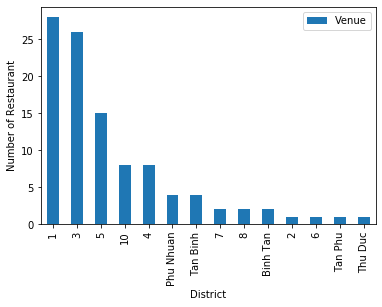

In [39]:
ax = restaurant_venues_district.sort_values(by="Venue", ascending=False).plot(x="District", y="Venue", kind="bar")
ax.set_ylabel("Number of Restaurant")

In [40]:
hcm_cluster = hochiminh_merged[['District','Cluster Labels']]

In [41]:
hochiminh_restaurant_cluster = pd.merge(hochiminh_data, hcm_cluster, how='left', left_on = 'District', right_on = 'District')
hochiminh_restaurant_cluster.dropna(inplace=True)

# Because the above reason so the type of Cluster Labels is float, we need to change type into interger
hochiminh_restaurant_cluster['Cluster Labels'] = hochiminh_restaurant_cluster['Cluster Labels'].astype('int32')
hochiminh_restaurant_cluster.head(20)

,District,Subdistrict,Area (km2),Population 2015,Density (pop/m2),Average Housing Price (1M VND),Latitude,Longitude,Cluster Labels
0,1,10 wards,7.73,193632,25049.418,430.0,10.774540,106.699184,0
1,2,11 wards,49.74,147168,2958.745,81.3,10.791116,106.736729,2
2,3,14 wards,4.92,196333,39905.081,272.0,10.783529,106.687098,0
3,4,15 wards,4.18,186727,44671.531,85.7,10.759243,106.704890,2
4,5,15 wards,4.27,178615,41830.211,256.0,10.756129,106.670375,1
5,6,14 wards,7.19,258945,36014.604,115.0,10.746928,106.634495,1
6,7,10 wards,35.69,310178,8690.894,86.7,10.736573,106.722432,0
7,8,16 wards,19.18,431969,22521.846,67.1,10.740400,106.665843,2
9,10,15 wards,5.72,238558,41705.944,213.0,10.773198,106.667833,0
13,Tan Binh,15 wards,22.38,459029,20510.679,150.0,10.797979,106.653805,1


From the above chart and table, we can dertermine the meaning of each cluster as follows:
+ Cluster 0: There is a lot of restaurant in there.
+ Cluster 1: The number of restaurant in these districts is medium.
+ Cluster 2: There are not many restaurants in these districts.

#### Therefore, with the purpose of opening a restaurant, we should find a location in which there is not a lot of competitor, available Housing Price, high Density. We choose to find Districts in Cluster 1. And we have to explore more factor below.

In [42]:
hochiminh_restaurant_new = hochiminh_restaurant_cluster[hochiminh_restaurant_cluster['Cluster Labels'] == 1]
hochiminh_restaurant_new.sort_values(by = 'Average Housing Price (1M VND)', ascending = True)

,District,Subdistrict,Area (km2),Population 2015,Density (pop/m2),Average Housing Price (1M VND),Latitude,Longitude,Cluster Labels
18,Binh Tan,10 wards,51.89,686474,13229.408,63.5,10.749809,106.605664,1
17,Thu Duc,12 wards,49.76,528413,10619.232,64.8,10.853246,106.765655,1
5,6,14 wards,7.19,258945,36014.604,115.0,10.746928,106.634495,1
13,Tan Binh,15 wards,22.38,459029,20510.679,150.0,10.797979,106.653805,1
16,Phu Nhuan,15 wards,4.88,182477,37392.828,185.0,10.800118,106.677042,1
4,5,15 wards,4.27,178615,41830.211,256.0,10.756129,106.670375,1


With the above table, we can see that District 6 have three available factors to open a new restaurant as below:
+ Cluster 1: The number of restaurant in these districts is medium.
+ Housing Price: in the medium range.
+ Density: High density.

### Conclusion

In general, the above project has been coming a conclusion that District 6 is available to open a new restaurant. But there is a lack of some factors needed to be considered such as: GDP per capita of each district, social environment, average salary of population.